# Capstone: 3
By Valerie Santiago Gonzalez


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
file_path = "/content/GrammarandProductReviews.csv"
df = pd.read_csv("/content/GrammarandProductReviews.csv")

# Display basic info
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  object 
 1   brand                 10001 non-null  object 
 2   categories            10001 non-null  object 
 3   dateAdded             10001 non-null  object 
 4   dateUpdated           10001 non-null  object 
 5   ean                   6866 non-null   object 
 6   keys                  10001 non-null  object 
 7   manufacturer          10001 non-null  object 
 8   manufacturerNumber    9983 non-null   object 
 9   name                  10001 non-null  object 
 10  reviews.date          9987 non-null   object 
 11  reviews.dateAdded     10001 non-null  object 
 12  reviews.dateSeen      10001 non-null  object 
 13  reviews.didPurchase   3637 non-null   object 
 14  reviews.doRecommend   9442 non-null   object 
 15  reviews.id         

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(                     id            brand  \
 0  AV13O1A8GV-KLJ3akUyj  Universal Music   
 1  AV14LG0R-jtxr-f38QfS         Lundberg   
 2  AV14LG0R-jtxr-f38QfS         Lundberg   
 3  AV16khLE-jtxr-f38VFn              K-Y   
 4  AV16khLE-jtxr-f38VFn              K-Y   
 
                                           categories             dateAdded  \
 0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
 1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
 2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
 3  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
 4  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
 
             dateUpdated          ean  \
 0  2018-02-05T08:36:58Z     6.03E+11   
 1  2018-02-05T11:27:45Z  73416000391   
 2  2018-02-05T11:27:45Z  73416000391   
 3  2018-02-05T11:25:51Z  67981934427   
 4  2018-02-05T11:25:51Z  67981934427   
 
    

# Observations

- Missing values:
  - reviews.didPurchase: ~64% missing
  - reviews.numHelpful: ~58% missing
  - reviews.userCity, userProvince: mostly missing
  - reviews.text: 2 missing values (can be dropped or filled)

- Date columns:
  - reviews.date needs to be converted to datetime.


# Next Steps: Preprocessing and EDA
1. Drop or fill missing values in:
  - reviews.text, reviews.rating, reviews.didPurchase
  - Convert reviews.date to datetime & explore time trends
2. Clean reviews.text:
  - Remove special chars & HTML
  - Tokenize + lemmatize
3. EDA Plots:
  - Rating distribution
  - Most reviewed brands
  - Helpful votes & recommendation stats
  - Time-based sentiment trends

In [15]:
# Handle missing values
df = df.dropna(subset=['reviews.text', 'reviews.rating'])
df['reviews.didPurchase'] = df['reviews.didPurchase'].fillna('Unknown')

# Convert reviews.date to datetime
df['reviews.date'] = pd.to_datetime(df['reviews.date'], errors='coerce')

# Count how many dates could not be parsed (just in case)
invalid_dates = df['reviews.date'].isna().sum()

# Set up NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define NLTK text cleaning function
def nltk_clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply text cleaning
df['cleaned_text'] = df['reviews.text'].apply(nltk_clean_text)

# Display data
df[['reviews.text', 'cleaned_text']].head(), invalid_dates

(                                        reviews.text  \
 0  i love this album. it's very good. more to the...   
 1  Good flavor. This review was collected as part...   
 2                                       Good flavor.   
 3  I read through the reviews on here before look...   
 4  My husband bought this gel for us. The gel cau...   
 
                                         cleaned_text  
 0  love album good hip hop side current pop sound...  
 1        good flavor review collected part promotion  
 2                                        good flavor  
 3  read review looking buying one couple lubrican...  
 4  husband bought gel u gel caused irritation fel...  ,
 np.int64(259))

In [16]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Summary stats for key fields
summary_stats = df[['reviews.rating', 'reviews.numHelpful']].describe()

# Most and least reviewed brands
brand_counts = df['brand'].value_counts()

# Ratings distribution per category
df['main_category'] = df['categories'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else 'Unknown')
category_rating = df.groupby('main_category')['reviews.rating'].value_counts(normalize=True).unstack().fillna(0)

# Trend: Average rating over time
rating_trend = df.groupby(df['reviews.date'].dt.to_period('M'))['reviews.rating'].mean().reset_index()
rating_trend['reviews.date'] = rating_trend['reviews.date'].dt.to_timestamp()

# Sentiment label from rating for trend (simplified)
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['reviews.rating'].apply(label_sentiment)
sentiment_trend = df.groupby([df['reviews.date'].dt.to_period('M'), 'sentiment']).size().unstack().fillna(0)
sentiment_trend.index = sentiment_trend.index.to_timestamp()

from IPython.display import display
print("EDA Summary Statistics:")
display(summary_stats)


EDA Summary Statistics:


,reviews.rating,reviews.numHelpful
count,9999.000000,4244.000000
mean,4.480648,0.474552
std,0.852142,3.732331
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,141.000000


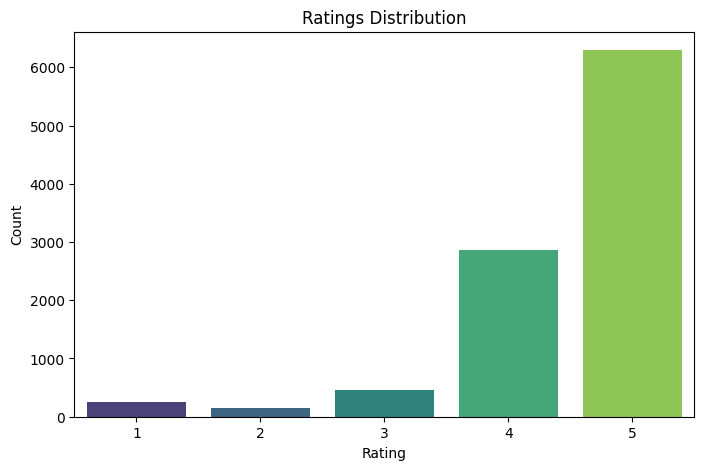

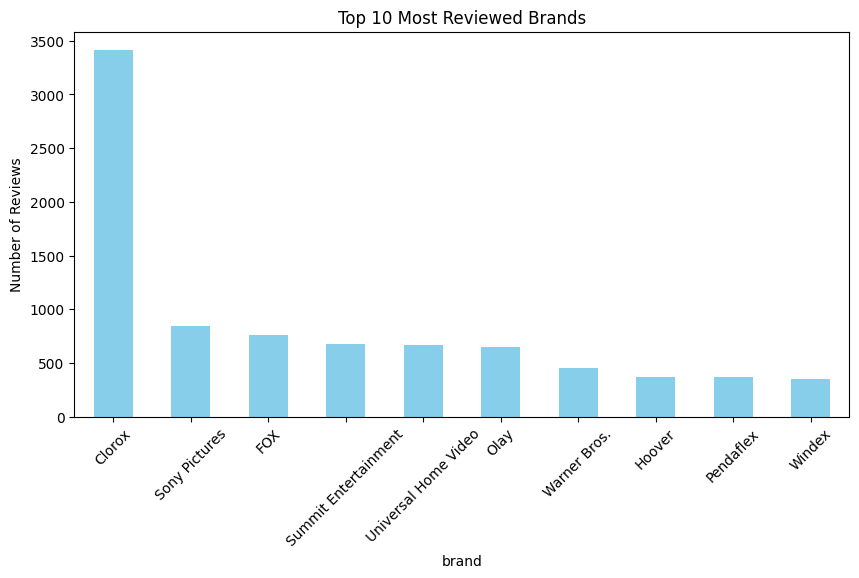

<Figure size 1200x600 with 0 Axes>

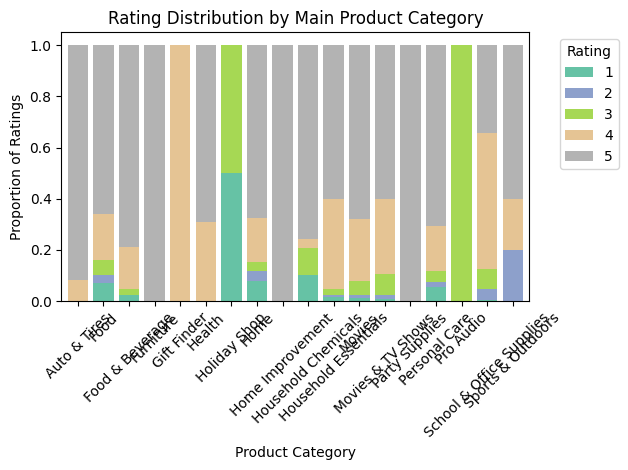

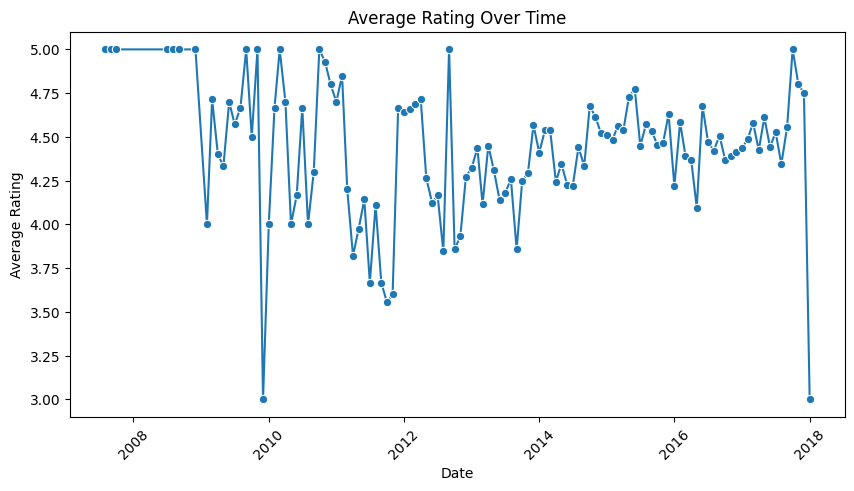

<Figure size 1000x500 with 0 Axes>

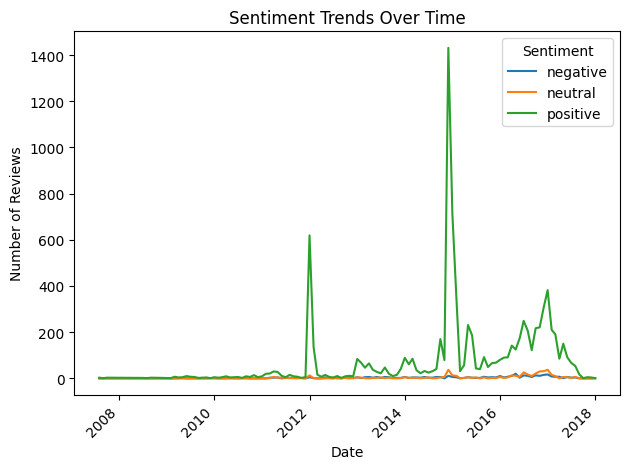

In [17]:

# Ratings distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='reviews.rating', palette='viridis')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 most reviewed brands
plt.figure(figsize=(10,5))
brand_counts.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Reviewed Brands")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

# Ratings per main category
plt.figure(figsize=(12,6))
category_rating.plot(kind='bar', stacked=True, colormap='Set2', width=0.8)
plt.title("Rating Distribution by Main Product Category")
plt.ylabel("Proportion of Ratings")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Average rating trend
plt.figure(figsize=(10,5))
sns.lineplot(data=rating_trend, x='reviews.date', y='reviews.rating', marker='o')
plt.title("Average Rating Over Time")
plt.ylabel("Average Rating")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

#  Sentiment trend over time
plt.figure(figsize=(10,5))
sentiment_trend.plot()
plt.title("Sentiment Trends Over Time")
plt.ylabel("Number of Reviews")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


# Insight Observations


- Rating Distribution is skewed toward positive reviews — a lot of 4s and 5s.
- Top Reviewed Brands include major companies like Clorox and Sony Pictures.
- Ratings by Category show some interesting diversity — e.g., Health and Home categories stand out with lower proportions of 5-star ratings, particularly high counts in the 1- to 3-star range. This may suggests customer dissatisfaction or inconsistency in product quality.
- Average Ratings Over Time are relatively stable, with some dips and spikes.
- Sentiment Trends show a consistent flow of positive sentiment, with occasional jumps in negative or neutral.


# Next Steps: Feature Engineering & Predictive Modeling

1. Create new features:
  - Review length
  - Sentiment polarity
  - Helpfulness score
2. Encode categorical variables
3. Use TF-IDF to convert reviews.text into numerical form.
4. Fake Review Detection with Machine Learning
  - Train Logistic Regression, Decision Trees, and Random Forests
  - Use Precision, Recall, and F1-score to evaluate model performance.
  - Isolation Forest, One-Class SVM


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

# Section 2: Feature Engineering & Predictive Modeling

# Review length (word count)
df['review_length'] = df['reviews.text'].apply(lambda x: len(str(x).split()))

# Sentiment polarity using TextBlob
df['polarity'] = df['reviews.text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Helpfulness score
df['helpfulness_score'] = df['reviews.numHelpful'] / (df['reviews.numHelpful'] + 1)

# Encode categorical variables
label_encoders = {}
for col in ['brand', 'categories', 'reviews.doRecommend']:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])

# Combine all features into a single dataset for modeling
features = df[['review_length', 'polarity', 'helpfulness_score',
               'brand_encoded', 'categories_encoded', 'reviews.doRecommend_encoded']].copy()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
features = pd.concat([features.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Target Variable
df['is_fake'] = df['reviews.numHelpful'].apply(lambda x: 1 if pd.isna(x) or x == 0 else 0)

# Final modeling dataset
X = features
y = df['is_fake']

X.shape, y.value_counts()


((9999, 506),
 is_fake
 1    9553
 0     446
 Name: count, dtype: int64)

# Feature engineering

- Total features: 506
- Target: is_fake
- Fake reviews (label 1): 9,553
- Genuine reviews (label 0): 446

There's a large class imbalance. I'll address this during modeling.



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Fake Review Detection with Machine Learning

# Handle missing values
X_clean = X.fillna(0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, stratify=y, test_size=0.2, random_state=42
)

# Reset index to align
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Undersample to balance classes
fake_reviews    = X_train[y_train == 1]
genuine_reviews = X_train[y_train == 0]
fake_labels     = y_train[y_train == 1]
genuine_labels  = y_train[y_train == 0]

# Sample fake reviews to match genuine count
fake_sampled         = fake_reviews.sample(n=len(genuine_reviews), random_state=42)
fake_labels_sampled  = fake_labels.loc[fake_sampled.index]

# Combine into a balanced dataset
X_balanced = pd.concat([genuine_reviews, fake_sampled], ignore_index=True)
y_balanced = pd.concat([genuine_labels, fake_labels_sampled], ignore_index=True)

# Initialize ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_balanced, y_balanced)
    y_pred = model.predict(X_test)
    report = classification_report(
        y_test,
        y_pred,
        target_names=["Genuine", "Fake"],
        output_dict=True
    )
    results[name] = report


# Function to format results
def format_results_table(report_dict):
    all_reports = []
    for model_name, report in report_dict.items():
        df = pd.DataFrame(report).transpose()
        df['model'] = model_name
        df = df.reset_index().rename(columns={'index': 'label'})
        all_reports.append(df)
    return pd.concat(all_reports, ignore_index=True)

readable_df = format_results_table(results)
filtered_readable_df = readable_df[
    readable_df['label'].isin(['Genuine', 'Fake', 'accuracy'])
]
# Display results
filtered_readable_df

,label,precision,recall,f1-score,support,model
0,Genuine,1.000000,1.00000,1.000000,89.0000,Logistic Regression
1,Fake,1.000000,1.00000,1.000000,1911.0000,Logistic Regression
2,accuracy,1.000000,1.00000,1.000000,1.0000,Logistic Regression
5,Genuine,1.000000,1.00000,1.000000,89.0000,Decision Tree
6,Fake,1.000000,1.00000,1.000000,1911.0000,Decision Tree
7,accuracy,1.000000,1.00000,1.000000,1.0000,Decision Tree
10,Genuine,0.967391,1.00000,0.983425,89.0000,Random Forest
11,Fake,1.000000,0.99843,0.999214,1911.0000,Random Forest
12,accuracy,0.998500,0.99850,0.998500,0.9985,Random Forest


In [20]:
# Show 'Fake' and 'accuracy' rows
final_filtered_df = readable_df[(readable_df['label'] == 'Fake') | (readable_df['label'] == 'accuracy')]
final_filtered_df

,label,precision,recall,f1-score,support,model
1,Fake,1.0000,1.00000,1.000000,1911.0000,Logistic Regression
2,accuracy,1.0000,1.00000,1.000000,1.0000,Logistic Regression
6,Fake,1.0000,1.00000,1.000000,1911.0000,Decision Tree
7,accuracy,1.0000,1.00000,1.000000,1.0000,Decision Tree
11,Fake,1.0000,0.99843,0.999214,1911.0000,Random Forest
12,accuracy,0.9985,0.99850,0.998500,0.9985,Random Forest


# Modeling Results:

- They're Almost Too Perfect
- Each model (Logistic Regression, Decision Tree, Random Forest) shows:
  - Accuracy: 100%
  - Precision, Recall, F1-Score: 1.00 for both fake and genuine reviews

- This may result in having a strongly predictive feature  (e.g., helpfulness score directly which comes from reviews.numHelpful, which we also used to label fake reviews).

- Next steps to fix this:
  - Remove helpfulness_score from features to avoid leakage.
  - Use another label for fake reviews (not only numHelpful == 0).

In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Remove 'helpfulness_score' to avoid target leakage
X_filtered = X.drop(columns=['helpfulness_score'])

# Re-split and re-balance the data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, stratify=y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

fake_reviews = X_train[y_train == 1]
genuine_reviews = X_train[y_train == 0]
fake_labels = y_train[y_train == 1]
genuine_labels = y_train[y_train == 0]

fake_sampled = fake_reviews.sample(n=len(genuine_reviews), random_state=42)
fake_labels_sampled = fake_labels.loc[fake_sampled.index]

X_balanced = pd.concat([genuine_reviews, fake_sampled], ignore_index=True)
y_balanced = pd.concat([genuine_labels, fake_labels_sampled], ignore_index=True)

# Re-train models
models = {
    "Logistic Regression (no leakage)": LogisticRegression(max_iter=1000),
    "Decision Tree (no leakage)": DecisionTreeClassifier(random_state=42),
    "Random Forest (no leakage)": RandomForestClassifier(n_estimators=100, random_state=42)
}

new_results = {}
for name, model in models.items():
    model.fit(X_balanced, y_balanced)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    new_results[name] = report

# Anomaly Detection: Unsupervised
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iso_forest.fit_predict(X_test)
iso_pred = [1 if x == -1 else 0 for x in iso_pred]  # -1 = anomaly

oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma='scale')
svm_pred = oc_svm.fit_predict(X_test)
svm_pred = [1 if x == -1 else 0 for x in svm_pred]  # -1 = anomaly

# Evaluate anomaly detection
iso_report = classification_report(y_test, iso_pred, target_names=["Genuine", "Fake"], output_dict=True)
svm_report = classification_report(y_test, svm_pred, target_names=["Genuine", "Fake"], output_dict=True)

new_results["Isolation Forest"] = iso_report
new_results["One-Class SVM"] = svm_report


# Function to format results
def format_results_table(report_dict):
    all_reports = []
    for model_name, report in report_dict.items():
        df = pd.DataFrame(report).transpose()
        df['model'] = model_name
        df = df.reset_index().rename(columns={'index': 'label'})
        all_reports.append(df)
    return pd.concat(all_reports, ignore_index=True)

# Results
readable_new_df = format_results_table(new_results)
filtered_new_df = readable_new_df[
    (readable_new_df['label'] == 'Fake') | (readable_new_df['label'] == 'accuracy')
]

filtered_new_df


,label,precision,recall,f1-score,support,model
2,accuracy,0.8035,0.803500,0.803500,0.8035,Logistic Regression (no leakage)
7,accuracy,0.8010,0.801000,0.801000,0.8010,Decision Tree (no leakage)
12,accuracy,0.8215,0.821500,0.821500,0.8215,Random Forest (no leakage)
16,Fake,0.8600,0.045003,0.085530,1911.0000,Isolation Forest
17,accuracy,0.0805,0.080500,0.080500,0.0805,Isolation Forest
21,Fake,0.8200,0.042909,0.081551,1911.0000,One-Class SVM
22,accuracy,0.0765,0.076500,0.076500,0.0765,One-Class SVM


# Models Observations

* **Random Forest (no leakage)** achieved the **highest overall accuracy** (82.15%) among the supervised models, outperforming both Logistic Regression and Decision Tree. This suggests it's the most reliable model for detecting fake reviews.

* **Logistic Regression** and **Decision Tree** showed **very similar performance** (both around \~80% accuracy), making them reasonable.

* **Anomaly detection models** (Isolation Forest and One-Class SVM) performed poorly in terms of accuracy (\~8%), but:

  * **Isolation Forest** achieved the **highest precision (86%)** for the **"Fake"** class. However, its **recall was very low (4.5%)**, meaning it correctly identified only a small fraction of actual fake reviews.
  * Similarly, **One-Class SVM** also had **high precision (82%)** but **very low recall (4.3%)**. These models are good at avoiding false positives but miss most of the actual fakes.

---

### Recommendation:

Random Forest (no leakage) is the best all-around option and would be a solid choice to use thanks to its strong, balanced performance. If catching fake reviews with high precision is especially important, Isolation Forest could be used as a backup filter, even though it tends to miss a lot of actual fakes.


In [10]:
# SECTION 4: Building a Review Summarization App using LLMs
!pip install gradio transformers --quiet

import gradio as gr
from transformers import pipeline

# Load summarization pipeline
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base")

# Function to split text into chunks of max_tokens
def split_text(text, max_tokens=900):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_tokens):
        chunk = " ".join(words[i:i + max_tokens])
        chunks.append(chunk)
    return chunks

# Function to summarize
def summarize_reviews(text):
    reviews = [r.strip() for r in text.split("|") if r.strip()]
    if not reviews:
        return "Please enter at least one review."

    combined_text = "summarize: " + " ".join(reviews)

    if len(combined_text.split()) < 50:
        return "Please enter more content for a meaningful summary."

    chunks = split_text(combined_text, max_tokens=900)

    summaries = summarizer(chunks, max_length=130, min_length=30, do_sample=False)
    return " ".join([s['summary_text'] for s in summaries])

# Gradio interface
gr.Interface(
    fn=summarize_reviews,
    inputs=gr.Textbox(lines=10, label="Enter reviews separated by |"),
    outputs=gr.Textbox(label="Generated Summary"),
    title="📝 Review Summarization App",
    description="Enter multiple customer reviews separated by |. This app uses an LLM to summarize them."
).launch()


Device set to use cuda:0


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cd6d57c050b90c5b38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Copy and Paste the following text to put into the gradio app to summarize:

I recently purchased this vacuum cleaner and I have to say, it completely changed my cleaning routine. The suction power is phenomenal and it picks up everything from pet hair to crumbs. It's also surprisingly quiet and lightweight, which makes it easy to carry around the house. | The first time I used this vacuum, I was impressed by how much dirt it pulled from the carpet. However, after a few weeks, the brush roller started making strange noises. Customer support was responsive, but I expected better durability. | Honestly, it’s a decent product for the price. It’s not perfect, but for a small apartment, it does the job well. The battery life could be better though. | I bought this for my elderly mother and she loves it. It’s easy for her to maneuver and not too heavy. The attachments are really useful for getting into corners and tight spots. | This vacuum cleaner works really well on hardwood floors but struggles a bit on thicker carpets. I also wish it came with a stand or wall mount for storage. Overall though, I’m happy with the purchase.